In [1]:
## import 套件
import torch
import pandas as pd
import numpy as np
import torch.nn as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AdamW ##新ㄉ 好像比較好
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import BertModel
from transformers import BertConfig

from matplotlib import pyplot as plt

In [2]:
## load data & path
columns_name = ['type','title','text']
dftrain = pd.read_csv('./data_after_sep/train.tsv',sep = '\t',names = columns_name)
dftest = pd.read_csv('./data_after_sep/test.tsv',sep = '\t',names = columns_name)
dfdev = pd.read_csv('./data_after_sep/dev.tsv',sep = '\t',names = columns_name)

model_path = './bert_pretrain_news/'
tokenizer = BertTokenizer.from_pretrained(model_path)

In [3]:
class TrainDataset(Dataset):
    def __init__(self, input_dict, y):
        self.input_ids = input_dict['input_ids']
        self.token_type_ids = input_dict['token_type_ids']
        self.attention_mask = input_dict['attention_mask']
        self.y = y
    def __getitem__(self, idx):
        input_id = self.input_ids[idx]
        tokentype = self.token_type_ids[idx]
        attentionmask = self.attention_mask[idx]
        y = self.y[idx]
        return input_id, tokentype, attentionmask, y
    def __len__(self):
        return len(self.input_ids)

In [4]:
# class PCADataset(Dataset):
#     def __init__(self,x,y):
#         self.x = x
#         self.y = y
#     def __getitem__(self,idx):
#         X = self.x[idx]
#         Y = self.y[idx]
#         return X, Y
#     def __len__(self):
#         return len(self.y)

In [4]:
train_x = dftrain['text'].tolist()
train_input_dict = tokenizer.batch_encode_plus(train_x,
                                              add_special_tokens = True,
                                              max_length = 512,
                                              truncation = True,                ##是否截斷
                                              return_special_tokens_mask = True,
                                              pad_to_max_length = True,
                                              return_tensors = 'pt')
BATCH_SIZE = 8
train_y = np.array(dftrain['type'].tolist())       ##np.array
trainset = TrainDataset(train_input_dict, train_y) ##trainset參數如init
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)  

In [5]:
test_x = dftest['text'].tolist()
test_input_dict = tokenizer.batch_encode_plus(test_x,
                                             add_special_tokens = True,
                                             max_length = 512,
                                             truncation = True,
                                             return_special_tokens_mask = True,
                                             pad_to_max_length = True,
                                             return_tensors = 'pt')
test_y = np.array(dftest['type'].tolist())
testset = TrainDataset(test_input_dict, test_y)
testloader = DataLoader(testset, batch_size = BATCH_SIZE, shuffle = True)


In [6]:
dev_x = dfdev['text'].tolist()
dev_input_dict = tokenizer.batch_encode_plus(test_x,
                                             add_special_tokens = True,
                                             max_length = 512,
                                             truncation = True,
                                             return_special_tokens_mask = True,
                                             pad_to_max_length = True,
                                             return_tensors = 'pt')
dev_y = np.array(dftest['type'].tolist())
devset = TrainDataset(dev_input_dict, test_y)
devloader = DataLoader(devset, batch_size = BATCH_SIZE, shuffle = True)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
## 類別對應 0：政治 1：生活 2：國際 3：體育 4：娛樂 5：社會 6：財經
def get_test_acc(model, testloader):
    model.eval()  ##test mode
    total = 0 ##total_num
    correct = 0 ##correct_num
    with torch.no_grad():   ##eval不計算gradient 
        for data in testloader:
            tokens_tensors , segment_tensors,masks_tensors,labels = [t.to(device) for t in data]
            outputs = model(input_ids = tokens_tensors,
                           token_type_ids = segment_tensors,
                           attention_mask = masks_tensors,
                           labels = labels)
            pred = torch.argmax(outputs[1],dim=-1)
            total += labels.size()[0]
            correct += (pred == labels).sum().item()
    
    return correct/total

In [9]:
# PCA_DIM = 768

# class PCA_linear(F.Module):
#     def __init__(self):
#         super(PCA_linear,self).__init__()
#         self.classifier = F.Sequential(
#             F.Linear(PCA_DIM,256),
#             F.Tanh(),
#             F.Linear(256,64),
#             F.ReLU(),
#             F.Linear(64,7)
#         )
#     def forward(self, x):
#         X = self.classifier(x)
#         return X
    

In [22]:
num_labels = 7
model = BertForSequenceClassification.from_pretrained(model_path,num_labels = num_labels)
model = model.to(device)
model.load_state_dict(torch.load('./BERT_for_PCA_AdamW1.pkl'))
model.eval()

test_acc = get_test_acc(model,testloader)
print('test acc:' , test_acc)

Some weights of the model checkpoint at ./bert_pretrain_news/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

test acc: 0.8464


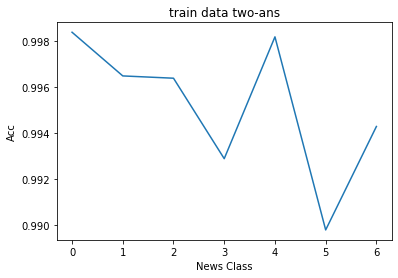

In [50]:
## 類別對應 0：政治 1：生活 2：國際 3：體育 4：娛樂 5：社會 6：財經
type_labels = ['0','1','2','3','4','5','6']
type_accs = [0.9984,0.9965,0.9964,0.9929,0.9982,0.9898,0.9943]
plt.title("train data two-ans") 
plt.xlabel("News Class") 
plt.ylabel("Acc") 
plt.plot(type_labels,type_accs)
plt.show()

In [49]:
def Sep_test_acc(model,testloader):
    model.eval()  ##test mode
    total = 0 ##total_num
    correct = 0 ##correct_num
    ##對應各類別的count
    label_list = ['政治','生活','國際','體育','娛樂','社會','財經']
    total_labels =[0,0,0,0,0,0,0]
    correct_labels = [0,0,0,0,0,0,0]
    with torch.no_grad():   ##eval不計算gradient 
        for data in testloader:
            tokens_tensors , segment_tensors,masks_tensors,labels = [t.to(device) for t in data]
            outputs = model(input_ids = tokens_tensors,
                               token_type_ids = segment_tensors,
                               attention_mask = masks_tensors,
                               labels = labels)
            pred = torch.argmax(outputs[1],dim=-1)
            total += labels.size()[0]
            for i in range(labels.size()[0]):
                total_labels[labels[i]] += 1
                if labels[i] == pred[i]:
                    correct_labels[labels[i]] += 1
            correct += (pred == labels).sum().item()
        
        for i in range(len(total_labels)):
            print(label_list[i],':',correct_labels[i],'/',total_labels[i], 'Acc :', (correct_labels[i]/total_labels[i]))
        print('Total：',correct/total)

In [51]:
def Sep_test_acc_two_ans(model,testloader):
    model.eval()  ##test mode
    total = 0 ##total_num
    correct = 0 ##correct_num
    ##對應各類別的count
    label_list = ['政治','生活','國際','體育','娛樂','社會','財經']
    total_labels =[0,0,0,0,0,0,0]
    correct_labels = [0,0,0,0,0,0,0]
    with torch.no_grad():   ##eval不計算gradient 
        for data in testloader:
            tokens_tensors , segment_tensors,masks_tensors,labels = [t.to(device) for t in data]
            outputs = model(input_ids = tokens_tensors,
                               token_type_ids = segment_tensors,
                               attention_mask = masks_tensors,
                               labels = labels)
            print(outputs[1])
            pred = torch.argmax(outputs[1],dim=-1)
            print(pred)
            for i in range(labels.size()[0]):
                outputs[1][i][pred[i]]= -9.9 #把最高調小一點
            pred_sec = torch.argmax(outputs[1],dim=-1)
            print(pred_sec)
            total += labels.size()[0]
            for i in range(labels.size()[0]):
                total_labels[labels[i]] += 1
                if labels[i] == pred[i] or labels[i] == pred_sec[i]:
                    correct_labels[labels[i]] += 1
            correct += (pred_sec == labels).sum().item()
            correct += (pred == labels).sum().item()
        
        for i in range(len(total_labels)):
            print(label_list[i],':',correct_labels[i],'/',total_labels[i], 'Acc :', (correct_labels[i]/total_labels[i]))
        print('Total：',correct/total)


In [52]:
Sep_test_acc_two_ans(model,testloader)

tensor([[ 7.2447, -0.9266, -1.1042, -2.2436, -1.2117, -1.3490, -1.1578],
        [ 1.5874,  5.8061, -2.1113, -2.8215, -1.6961, -1.1711,  0.3743],
        [-0.6978,  1.5740, -0.5188, -2.2546, -1.8852, -1.8251,  4.7538],
        [-1.1939, -0.8933,  3.1182, -2.5321, -2.8419, -2.8738,  4.8393],
        [ 3.1516,  4.0323, -1.0255, -3.4480, -1.4164, -2.0886, -0.1575],
        [ 7.3209, -0.4119, -1.1651, -2.3602, -1.1747, -1.5957, -1.3370],
        [-1.8787, -0.5953,  0.0657,  5.3578, -0.0669, -1.5128, -1.6692],
        [-0.2856,  4.9688,  1.5760, -2.7081, -1.0689, -2.6740, -0.0808]],
       device='cuda:0')
tensor([0, 1, 6, 6, 1, 0, 3, 1], device='cuda:0')
tensor([1, 0, 1, 2, 0, 1, 2, 2], device='cuda:0')
tensor([[-0.9697,  5.6914, -0.0502, -2.3946,  0.7628, -1.8039, -1.2869],
        [ 5.7884,  2.9026, -1.7954, -3.2835, -1.6561, -1.5768, -0.3754],
        [ 6.0255,  1.6943, -1.5922, -3.2775, -1.6991, -2.0331,  0.5024],
        [-0.2817, -1.4090, -1.2470, -1.1897,  7.1732, -1.4721, -1.5475],

tensor([2, 3, 1, 6, 1, 1, 2, 6], device='cuda:0')
tensor([[ 0.7235, -1.1838,  5.3806, -2.0159, -1.5362, -2.4032, -1.4587],
        [ 0.1214,  4.6495, -2.0763, -2.4418, -1.4655,  3.9520, -0.2710],
        [ 1.7664,  4.3088, -1.7155, -3.2277, -0.2672, -2.5919,  0.6967],
        [-2.0014, -1.4452,  6.1869, -1.4647, -0.8217, -2.3744, -0.2972],
        [ 7.1063, -0.6106, -0.6320, -2.6226, -1.2015, -2.0782, -1.0922],
        [-1.7311,  0.3678, -0.1171, -2.0317, -1.7710, -1.3717,  5.5852],
        [-0.7729, -0.2641, -0.4782, -1.3815,  6.1140, -1.9246, -1.5896],
        [-0.0521,  6.1162, -1.6847, -2.9376, -2.3186,  1.1432,  0.2726]],
       device='cuda:0')
tensor([2, 1, 1, 2, 0, 6, 4, 1], device='cuda:0')
tensor([0, 5, 0, 6, 1, 1, 1, 5], device='cuda:0')
tensor([[-0.5883, -0.9380, -0.3289, -0.7718, -0.7223,  6.5894, -0.9929],
        [-1.9605,  1.6314,  0.3781, -1.7199,  1.4208, -2.0944,  2.2125],
        [ 6.8433,  1.2525, -1.0962, -2.9725, -1.8041, -1.6973, -1.2104],
        [-1.6628, -1.0

tensor([0, 5, 0, 0, 4, 4, 4, 3], device='cuda:0')
tensor([1, 1, 5, 2, 0, 0, 0, 2], device='cuda:0')
tensor([[ 4.3348,  3.3758, -1.2413, -3.2167, -1.1193, -2.7823, -0.1167],
        [-0.7301, -0.2102, -0.3088, -1.1171, -0.7834,  6.6911, -1.0838],
        [-1.3101,  5.9476, -0.6748, -2.1477, -0.9993, -1.2553,  0.6396],
        [-0.0838, -0.7019, -1.2823, -1.5790,  6.4283, -1.5750, -1.3509],
        [-1.3924,  1.8085, -0.2744, -2.2165,  4.2610, -1.8679, -0.5381],
        [-1.4944,  5.4842,  0.9975, -2.3619, -0.7701, -1.5265, -0.4846],
        [-0.8533,  3.5441, -1.1685, -1.9355, -0.3446, -1.7150,  2.3186],
        [ 6.3805,  0.5653, -0.8942, -2.8721, -0.4037, -2.7228, -1.4328]],
       device='cuda:0')
tensor([0, 5, 1, 4, 4, 1, 1, 0], device='cuda:0')
tensor([1, 1, 6, 0, 1, 2, 6, 1], device='cuda:0')
tensor([[-0.9051,  3.9325, -1.5549, -1.7962, -1.4066,  5.5335, -0.1923],
        [-0.7498, -0.5531,  2.3746, -2.5573, -2.6233, -2.8785,  4.8933],
        [-1.4969, -0.2200, -0.8686,  5.3768, 

tensor([6, 2, 6, 2, 1, 2, 0, 1], device='cuda:0')
tensor([[ 6.3289,  1.4630, -0.5039, -2.8967, -2.5638, -1.9493, -1.0736],
        [-0.8800,  0.8184,  3.8652, -2.4556,  0.9043, -2.5760, -0.9160],
        [-1.8122, -0.8971,  0.2109,  5.1896,  0.0086, -1.6202, -1.5228],
        [-1.6780,  1.1704, -0.1647, -1.6048, -1.2013, -1.4537,  4.5031],
        [-1.1667,  1.9514,  1.1786, -2.6099,  2.9661, -2.5661, -0.5753],
        [-0.5402, -0.8035, -0.9829, -1.3878,  6.8186, -1.8746, -1.5184],
        [-0.2639, -1.5758, -0.8520, -1.0794,  6.9354, -1.7301, -1.7408],
        [-1.6790, -0.2101,  5.8997, -2.1008, -1.3222, -2.6295,  0.1828]],
       device='cuda:0')
tensor([0, 2, 3, 6, 4, 4, 4, 2], device='cuda:0')
tensor([1, 4, 2, 1, 1, 0, 0, 6], device='cuda:0')
tensor([[-1.9200,  3.3718, -1.0900, -1.5197, -0.4720, -1.2043,  2.9245],
        [ 3.0355,  3.9774, -0.8477, -3.5445, -1.6182, -2.2949,  0.1609],
        [-1.7856, -0.7263, -0.5176,  5.9093, -0.2132, -1.3889, -1.4483],
        [ 7.2944, -1.0

tensor([4, 6, 1, 2, 1, 6, 1, 1], device='cuda:0')
tensor([[-2.4157,  1.3956,  0.3511, -1.6112, -0.4353, -1.8360,  3.9203],
        [ 4.3618,  3.7084, -1.6390, -3.2252, -0.9420, -2.3572, -0.4760],
        [ 7.1510, -0.4681, -0.9095, -2.5651, -0.6862, -1.7982, -1.6099],
        [-1.8357,  0.6946, -0.2902, -1.8474, -1.5696, -1.4421,  5.2522],
        [ 7.2147, -0.5185, -0.9456, -2.3923, -1.6455, -1.4655, -1.1035],
        [-1.5800,  3.6733,  0.7686, -2.2580,  2.5661, -2.3478, -1.2465],
        [-0.3622,  0.0981, -0.5092, -1.4375,  5.7742, -2.3116, -1.9078],
        [ 7.3074, -0.3689, -1.0179, -2.4028, -1.0349, -1.9084, -1.3753]],
       device='cuda:0')
tensor([6, 0, 0, 6, 0, 1, 4, 0], device='cuda:0')
tensor([1, 1, 1, 1, 1, 4, 1, 1], device='cuda:0')
tensor([[-1.7969, -0.9163,  0.0869,  5.2235,  0.0544, -1.6399, -1.3153],
        [-1.1032,  6.5724, -1.0199, -1.8800, -1.5583, -0.5307, -0.1721],
        [-0.6566,  1.9878, -0.9032, -0.0758, -0.7913, -1.5158,  2.2362],
        [-1.4416,  4.2

tensor([[-0.4727,  0.9380, -0.1561, -2.1435,  4.7087, -2.0001, -1.2942],
        [-2.2372, -1.4155,  6.2255, -1.1515, -0.7670, -1.6352, -0.6651],
        [ 0.3083, -0.7202, -1.0185, -1.6277,  6.3291, -1.8580, -1.6690],
        [-1.1043,  3.3381, -0.8711, -2.1493, -0.6249, -1.7801,  2.9728],
        [-2.3855, -0.8021,  6.1244, -1.2326, -0.4580, -2.2291, -0.7274],
        [-1.2433,  1.0322, -0.6534, -1.2285, -0.9296,  6.8482, -0.7991],
        [-1.1368, -0.1344,  1.9245, -2.4710, -1.9903, -2.7905,  4.8440],
        [-0.7563,  5.9547, -1.6332, -2.2311,  0.8156, -1.3890, -0.8123]],
       device='cuda:0')
tensor([4, 2, 4, 1, 2, 5, 6, 1], device='cuda:0')
tensor([1, 6, 0, 6, 4, 1, 2, 4], device='cuda:0')
tensor([[-2.0119,  2.1797, -0.4271, -1.9238, -1.7720, -1.3112,  4.5655],
        [-1.8266,  0.4414, -1.1180,  3.9794,  1.5595, -1.2239, -1.5745],
        [-1.6118, -0.4506,  1.5819, -2.0547, -2.3459, -2.1952,  5.4372],
        [ 6.9829,  0.5347, -1.2608, -2.8790, -1.7253, -1.8154, -0.6008],

tensor([1, 5, 2, 3, 1, 0, 1, 4], device='cuda:0')
tensor([4, 1, 6, 4, 0, 6, 6, 1], device='cuda:0')
tensor([[ 0.8192,  2.0021,  3.5360, -2.9151, -2.0705, -2.4950, -0.7011],
        [-1.1443,  6.0014, -0.4562, -2.0660, -1.1966, -1.4014,  0.0999],
        [-1.4042,  5.6543, -1.4906, -2.0073, -1.4521,  3.8060, -0.6499],
        [-0.5038,  6.7202, -1.8287, -2.0984, -0.4966, -0.7635, -0.8754],
        [ 1.4234,  2.2588, -1.0633, -3.3883, -1.6342, -1.6259,  3.5302],
        [-1.6277,  0.6502, -0.1603, -1.9447, -2.0282, -1.0914,  5.4122],
        [-1.3543,  3.5791, -0.9308, -1.5242,  0.3312, -1.8201,  1.7213],
        [ 7.0663, -0.7363, -1.0412, -2.4621, -1.4578, -1.6250, -0.6081]],
       device='cuda:0')
tensor([2, 1, 1, 1, 6, 6, 1, 0], device='cuda:0')
tensor([1, 6, 5, 4, 1, 1, 6, 6], device='cuda:0')
tensor([[ 0.2925, -0.4886, -1.0965, -1.6927,  6.3138, -1.8301, -1.6454],
        [-1.7675, -1.1312,  6.1851, -1.6839, -0.7674, -2.1997, -0.6443],
        [ 6.7011,  0.1882, -1.1590, -2.7723, 

tensor([3, 6, 2, 0, 0, 1, 3, 0], device='cuda:0')
tensor([2, 2, 0, 5, 1, 5, 2, 1], device='cuda:0')
tensor([[ 1.6718,  0.9248,  0.5030, -2.6228, -1.6123,  2.9472, -1.0821],
        [-0.1161, -1.2260, -1.2787, -1.3936,  7.1589, -1.5241, -1.6521],
        [ 5.3650,  1.7029,  0.1311, -3.1490, -1.8821, -2.0916, -1.3866],
        [-1.9465,  1.5774, -0.5462, -1.6621, -1.6094, -1.3430,  4.7334],
        [ 6.6550,  1.6699, -1.6414, -2.9557, -1.7744, -2.1230, -0.5371],
        [-0.3337, -1.2366, -1.1182, -1.3010,  7.1128, -1.5663, -1.6716],
        [-1.2107,  4.3828, -1.5140, -1.4474, -1.0526, -1.5203,  2.3737],
        [-1.4197,  0.3236, -0.4687,  4.6619, -0.3013, -1.4985, -1.7499]],
       device='cuda:0')
tensor([5, 4, 0, 6, 0, 4, 1, 3], device='cuda:0')
tensor([0, 0, 1, 1, 1, 0, 6, 1], device='cuda:0')
tensor([[-1.8431, -0.4976, -0.2541,  5.3420, -0.1802, -1.5442, -1.3101],
        [-1.8206,  0.6994,  5.4830, -2.2024, -1.6463, -2.6503,  0.6682],
        [-1.7872, -0.5764,  0.2162,  5.1486, 

tensor([3, 3, 6, 2, 0, 0, 0, 0], device='cuda:0')
tensor([2, 4, 1, 3, 1, 1, 1, 1], device='cuda:0')
tensor([[ 2.5272,  3.0486,  1.2658, -3.3810, -1.8765, -2.7113, -0.3032],
        [ 4.7499,  2.9773, -1.7540, -3.2116, -1.2426, -2.3141,  0.5246],
        [-1.4508, -0.1958, -0.4870,  4.9264,  0.0811, -1.4295, -1.6420],
        [ 0.1710,  2.7737, -0.4254, -3.1668, -0.3958, -2.5145,  2.5520],
        [ 0.9765,  5.6370, -1.6673, -2.6566, -0.1349, -1.6607, -0.6961],
        [-0.1708, -1.4572, -1.2454, -1.3302,  7.2476, -1.3912, -1.5780],
        [ 7.0658, -1.3562, -1.1796, -1.8286, -1.1351, -0.8118, -1.4035],
        [-1.4210,  1.6767, -0.4351, -1.5498, -1.3406, -0.6279,  3.8839]],
       device='cuda:0')
tensor([1, 0, 3, 1, 1, 4, 0, 6], device='cuda:0')
tensor([0, 1, 4, 6, 0, 0, 5, 1], device='cuda:0')
tensor([[-0.4522,  2.3338, -1.7684,  3.1664, -0.8993, -1.3553, -1.4139],
        [-0.9448,  3.7296, -0.1137, -2.9398,  2.9388, -1.9542, -0.9756],
        [-2.2682, -0.8638,  4.0123, -0.7850, 

tensor([2, 6, 2, 2, 2, 2, 4, 0], device='cuda:0')
tensor([6, 4, 6, 1, 6, 6, 0, 1], device='cuda:0')
tensor([[ 0.1733,  6.0865, -1.6227, -2.1720, -1.2014, -1.3232,  0.1187],
        [ 5.2143, -0.4655,  0.9280, -2.9295, -2.3434, -1.4730, -1.0786],
        [ 7.1051, -1.4696, -0.9483, -1.9872, -1.2852, -1.0511, -1.1003],
        [-1.5894, -0.5163, -0.2186, -1.4245,  4.4363, -2.0584,  1.4693],
        [ 0.3746,  6.6007, -0.9978, -2.2212, -1.5091, -1.6508, -0.7299],
        [ 2.6258,  4.6633, -2.0470, -3.0661, -1.2236, -2.1116,  0.8424],
        [-0.3553, -1.4635, -0.9315, -1.3061,  7.2386, -1.5022, -1.7579],
        [-0.5950, -0.9698, -0.4085, -0.7360, -0.7913,  6.5910, -0.8133]],
       device='cuda:0')
tensor([1, 0, 0, 4, 1, 1, 4, 5], device='cuda:0')
tensor([0, 2, 2, 6, 0, 0, 0, 2], device='cuda:0')
tensor([[-2.0496,  2.0325, -0.2025, -1.5788, -0.3536, -1.5845,  3.5217],
        [-0.9700,  6.9745, -1.3344, -1.8789, -1.6798,  0.5261, -0.9193],
        [ 7.1650, -1.1316, -1.1578, -1.9495, 

tensor([[ 5.5154, -0.5383,  0.8684, -3.0705, -1.6448, -2.2164, -1.2131],
        [-1.3944,  2.7250,  0.9131, -1.8561,  2.0185, -2.5426,  0.0810],
        [-1.6680,  4.9023, -0.1856, -2.3043,  0.1885, -1.8728,  0.8628],
        [-1.7561, -0.1995,  4.2438, -2.3348, -2.1821, -2.9689,  3.3605],
        [ 3.8574,  2.4658, -1.0709, -3.4941, -1.8675, -3.1217,  1.6426],
        [-0.8669,  0.7866, -0.0860, -2.0251, -2.0922, -2.0159,  5.0996],
        [-0.5883,  0.0910,  0.5571, -2.5497, -2.0977, -2.3559,  5.2686],
        [ 7.3460, -0.8580, -1.3116, -1.9656, -1.2686, -1.0243, -1.5168]],
       device='cuda:0')
tensor([0, 1, 1, 2, 0, 6, 6, 0], device='cuda:0')
tensor([2, 4, 6, 6, 1, 1, 2, 1], device='cuda:0')
tensor([[ 0.4709,  1.3723,  1.5036, -3.3359,  0.6672, -2.6938,  0.5812],
        [-1.6120,  0.5659, -0.1553, -2.0143, -1.9141, -1.5043,  5.5161],
        [ 7.2385, -1.1646, -1.3440, -1.7067, -1.3846, -0.8263, -1.3196],
        [ 6.0447,  0.5690, -0.5395, -3.1937, -0.4499, -2.6108, -1.2158],

tensor([[-1.6285,  0.3259,  4.4414, -2.6583, -2.0653, -2.8717,  2.8789],
        [-1.2533,  6.2687, -1.4831, -2.0215,  0.9435, -0.8706, -1.4064],
        [ 2.0811,  4.8828, -0.2779, -3.3134, -1.6379, -1.5619, -0.6268],
        [-0.7902,  0.4791, -0.7570,  4.3736, -0.9273, -1.6967, -1.6187],
        [-2.0333,  5.2970, -1.3939, -1.9720, -0.8718, -1.0489,  2.0436],
        [ 7.1227, -1.3432, -1.2081, -1.9272, -0.9023, -0.8673, -1.4681],
        [-0.5559,  5.6778, -1.7677, -2.4875,  1.3038, -1.5643, -0.7451],
        [-0.9319,  6.4913, -0.9283, -1.8129, -1.6194, -0.8904, -0.2622]],
       device='cuda:0')
tensor([2, 1, 1, 3, 1, 0, 1, 1], device='cuda:0')
tensor([6, 4, 0, 1, 6, 5, 4, 6], device='cuda:0')
tensor([[-1.1734,  6.4379, -1.4006, -1.4994, -1.8024, -0.3219,  0.1370],
        [ 3.3008,  2.7669, -1.6544, -3.1723, -2.1769, -2.2875,  2.7582],
        [-1.6824,  0.6334, -0.1542, -1.8415, -1.8438, -1.5782,  5.3131],
        [-1.3223,  1.2469,  0.9295, -2.4362, -1.6768, -2.5827,  4.6880],

tensor([[ 7.3102e+00,  3.3876e-01, -1.5744e+00, -2.2114e+00, -1.6732e+00,
         -1.4602e+00, -1.2344e+00],
        [-1.6121e+00,  3.7369e+00, -1.1883e+00, -1.9369e+00, -1.8730e+00,
         -5.2908e-01,  3.5932e+00],
        [ 4.9892e-01,  6.7053e+00, -2.1368e+00, -2.2065e+00, -1.3078e+00,
         -3.8021e-01, -8.4851e-01],
        [-1.0524e+00,  6.8469e+00, -1.2562e+00, -1.4902e+00, -1.2797e+00,
         -5.8333e-01, -9.0766e-01],
        [ 4.4935e+00,  2.0875e+00, -1.1601e+00, -3.5382e+00, -3.2318e-01,
         -2.9300e+00,  3.7302e-01],
        [-1.6639e+00,  1.9384e+00, -6.0427e-01, -8.8489e-01,  2.5429e-01,
         -1.1915e+00,  2.3231e+00],
        [-1.3939e+00,  1.9218e+00, -1.3125e+00, -1.0901e+00, -6.3243e-01,
          3.3919e+00,  1.8233e+00],
        [-1.3330e+00, -6.4323e-03, -1.0411e+00,  5.1465e+00,  2.0811e-01,
         -1.1741e+00, -1.8344e+00]], device='cuda:0')
tensor([0, 1, 1, 1, 0, 6, 5, 3], device='cuda:0')
tensor([1, 6, 0, 5, 1, 1, 1, 4], device='cuda:0')
te

tensor([1, 6, 1, 4, 1, 1, 6, 4], device='cuda:0')
tensor([[-0.2103, -1.4222, -1.2422, -1.1602,  7.1974, -1.6036, -1.6223],
        [ 4.4073, -1.6298,  2.6827, -2.1930, -2.2363, -2.3627, -1.4047],
        [-1.2559,  5.1869, -0.1800, -2.7535, -0.2451, -1.9237,  0.9132],
        [-0.1127, -1.6101, -1.1524, -1.0371,  7.0772, -1.5516, -1.6117],
        [ 7.1766, -1.4399, -0.9088, -1.8302, -0.5432, -1.7859, -1.5789],
        [ 7.2102, -0.1644, -1.2252, -2.3699, -1.9070, -1.2016, -1.0580],
        [-1.8503, -0.6210,  0.1359,  5.3643, -0.5251, -1.5922, -1.3824],
        [ 0.3333, -0.7600, -1.1577, -1.5049,  6.4047, -1.8834, -1.6311]],
       device='cuda:0')
tensor([4, 0, 1, 4, 0, 0, 3, 4], device='cuda:0')
tensor([0, 2, 6, 0, 4, 1, 2, 0], device='cuda:0')
tensor([[-1.6329,  1.1402, -0.3002, -1.5219, -0.8902,  6.6180, -0.7019],
        [-1.1703,  2.5827, -1.2378, -1.7880, -1.1570,  6.3158, -0.2188],
        [-0.6786,  0.1318, -0.8173, -1.0314, -0.9385,  6.8678, -0.8335],
        [-0.4952, -0.0

tensor([[-1.3532,  6.0769, -1.4236, -1.7746,  0.9888, -1.2805, -1.1662],
        [-1.1705,  1.3143, -0.3322, -2.3000, -2.0081, -1.5711,  5.0657],
        [-0.2863, -0.4907,  1.8144, -2.5422, -1.9456, -3.0656,  4.6235],
        [-0.9806,  6.8091, -1.5721, -1.8972, -1.9652,  0.8748, -0.3758],
        [-1.8179, -0.6487,  1.3312, -1.7058, -2.1329, -2.1228,  5.5606],
        [-1.8151,  0.1478, -0.0589, -1.8336, -1.7071, -1.4811,  5.5869],
        [-1.4349, -1.4329,  3.6333, -2.1635, -2.5174, -3.0092,  4.5882],
        [ 1.8475,  1.3888, -0.7953, -3.0953, -1.7288, -2.8167,  3.7308]],
       device='cuda:0')
tensor([1, 6, 6, 1, 6, 6, 6, 6], device='cuda:0')
tensor([4, 1, 2, 5, 2, 1, 2, 0], device='cuda:0')
tensor([[-1.3392, -0.7122,  1.7838, -2.0263, -2.3725, -2.4942,  5.4112],
        [-1.5613,  1.1416, -0.7707, -0.5680, -1.1125,  0.8682,  3.2566],
        [-1.5859,  5.7692, -1.2617, -1.4328,  1.0152, -0.9430, -1.0143],
        [-1.7259,  0.5131, -0.3006, -1.9635, -1.8135, -1.3290,  5.5796],

tensor([[ 7.1697, -1.0956, -0.8226, -2.2590, -1.1464, -1.5483, -1.1767],
        [-2.1998, -0.0632,  5.5938, -1.8721, -0.4473, -2.5422,  0.1466],
        [-1.7882, -0.5142,  2.2370, -2.2951, -2.5699, -2.3568,  5.4506],
        [-1.2988, -1.7714,  6.0941, -1.8153, -1.3450, -2.5067,  0.0861],
        [-2.3222,  2.0191, -0.8892, -1.1030, -0.5107, -0.6605,  3.4622],
        [-0.7672, -1.4249,  5.8111, -2.1570, -1.5184, -2.2165, -0.1426],
        [-1.0557, -0.0968, -0.1047, -1.2271, -0.7027,  6.6427, -1.0749],
        [ 0.0249,  3.6378,  0.4040, -2.5383,  0.9762, -2.7640, -0.0107]],
       device='cuda:0')
tensor([0, 2, 6, 2, 6, 2, 5, 1], device='cuda:0')
tensor([2, 6, 2, 6, 1, 6, 1, 4], device='cuda:0')
tensor([[-0.2002, -0.7167, -1.0176, -1.5564,  6.6436, -1.7216, -1.6148],
        [ 6.2175,  1.9888, -1.3727, -2.9850, -1.7321, -2.5450, -0.3363],
        [-1.0827,  5.4214, -1.1529, -2.4084,  2.0659, -1.3553, -1.2989],
        [ 3.2404,  2.1839,  0.6800, -3.1412, -1.2206, -2.2482, -0.7153],

tensor([6, 1, 0, 6, 2, 1, 4, 6], device='cuda:0')
tensor([1, 4, 5, 1, 6, 4, 0, 1], device='cuda:0')
tensor([[-0.1077,  4.2537, -0.0686, -2.9135,  1.5174, -2.4861, -0.4176],
        [ 2.7882,  5.1479, -2.1799, -2.8547, -1.7897, -1.4084,  0.0354],
        [-1.6330,  1.4203,  5.1961, -2.2889, -1.4127, -2.6023,  0.1474],
        [-0.1780, -0.7942, -0.7551, -1.3922,  6.3730, -1.8749, -1.7144],
        [-0.7612,  6.3059, -1.2204, -1.4730, -1.5232, -0.9914, -0.2081],
        [-1.3887,  5.1756, -1.2161, -2.2645,  1.4499, -1.6867, -0.1770],
        [-0.8593,  0.8254, -0.7867, -1.2387, -0.8801,  6.8842, -1.0133],
        [-0.2837,  4.5213, -1.1723,  0.9454, -1.1593, -1.6394, -1.2557]],
       device='cuda:0')
tensor([1, 1, 2, 4, 1, 1, 5, 1], device='cuda:0')
tensor([4, 0, 1, 0, 6, 4, 1, 3], device='cuda:0')
tensor([[-0.7514,  0.7552, -0.9938, -1.2262, -0.9573,  6.8617, -0.7788],
        [ 4.8157,  1.8290, -0.1634, -3.4053, -2.0349, -2.2201, -0.0596],
        [-1.8494,  1.5878, -0.3226, -1.9212, 

tensor([[-0.1025, -0.7910, -0.9054, -1.3384,  6.5470, -1.9467, -1.7617],
        [-0.2652,  2.0807,  4.3725, -2.7279, -1.5088, -2.7652, -0.3581],
        [-1.9077, -0.1089,  6.0478, -2.0468, -1.7207, -2.5549,  0.4894],
        [ 6.7374,  0.7603, -1.1151, -3.1945, -1.4312, -1.3042, -0.9843],
        [ 2.7838,  3.6728, -0.8362, -3.6577, -0.7009, -2.3344,  0.3146],
        [-1.9265, -0.8548,  0.0673,  5.5703, -0.0215, -1.5299, -1.5817],
        [-1.3553, -0.9867,  4.0187, -2.5715, -2.7306, -3.0330,  4.2564],
        [-1.1569,  0.6256,  3.5795, -2.2090,  0.5783, -3.0216,  0.5292]],
       device='cuda:0')
tensor([4, 2, 2, 0, 1, 3, 6, 2], device='cuda:0')
tensor([0, 1, 6, 1, 0, 2, 2, 1], device='cuda:0')
tensor([[-1.9067, -0.8774,  5.7149, -1.9876, -1.8010, -2.8530,  1.6588],
        [ 7.1842, -1.5062, -1.0376, -1.7714, -1.1789, -0.8957, -1.4409],
        [-0.7072, -0.4384, -0.3942, -0.8738, -0.9081,  6.7365, -1.0035],
        [-0.4721, -1.5629, -1.1925, -1.2284,  7.3714, -1.2690, -1.5535],

tensor([0, 0, 0, 1, 6, 2, 6, 0], device='cuda:0')
tensor([[-2.2380e+00,  6.1402e-01,  5.1336e+00, -1.6959e+00, -3.8994e-03,
         -2.7223e+00, -3.3284e-01],
        [-4.0683e-01,  5.2295e+00, -9.3444e-02, -3.3785e+00,  1.3310e-01,
         -1.7735e+00,  3.1356e-02],
        [ 6.3509e-01,  3.8732e+00, -1.7253e+00, -2.6718e+00,  7.6070e-01,
         -2.1174e+00,  1.1170e+00],
        [ 6.2753e+00,  2.1007e+00, -1.5216e+00, -2.9883e+00, -1.2081e+00,
         -1.8317e+00, -1.0758e+00],
        [ 8.9700e-01,  6.5463e+00, -2.1812e+00, -2.1966e+00, -9.0733e-01,
         -9.3789e-01, -1.0815e+00],
        [-2.1346e+00, -8.5410e-01,  1.3580e+00, -1.4337e+00, -2.0258e+00,
         -1.9151e+00,  5.5373e+00],
        [-1.8863e+00,  1.5849e+00,  3.9571e+00, -2.0563e+00,  4.4257e-01,
         -2.6874e+00, -1.3235e-01],
        [-2.2135e-02, -6.3633e-01, -8.7349e-01, -1.4718e+00,  6.2453e+00,
         -1.9049e+00, -1.6018e+00]], device='cuda:0')
tensor([2, 1, 1, 0, 1, 6, 2, 4], device='cuda:0')
te

tensor([6, 6, 4, 6, 0, 5, 1, 0], device='cuda:0')
tensor([2, 2, 0, 1, 5, 6, 0, 5], device='cuda:0')
tensor([[-1.7319,  1.0723, -0.2480, -1.8831, -1.8689, -1.3801,  5.0728],
        [-0.7700,  2.0892, -1.2628, -1.4690, -1.0004,  6.6157, -0.8889],
        [ 6.8951,  0.1917, -0.3820, -2.8564, -1.4048, -2.2142, -1.5213],
        [-1.4946, -0.2093,  1.6616, -2.4371, -2.2441, -2.4571,  5.4230],
        [ 5.5457, -0.0351,  0.8816, -3.0489, -2.3266, -2.0053, -1.1727],
        [-0.4476,  6.5447, -1.8194, -2.0566, -1.0022, -0.7780, -0.4444],
        [-1.8775,  1.5310, -0.3678, -1.2466, -0.7085, -1.1629,  3.6823],
        [-1.9363, -1.2899,  0.6497,  4.6692,  0.5768, -1.7156, -1.4919]],
       device='cuda:0')
tensor([6, 5, 0, 6, 0, 1, 6, 3], device='cuda:0')
tensor([1, 1, 1, 2, 2, 6, 1, 2], device='cuda:0')
tensor([[-1.5639, -0.2741,  4.0451, -2.3030, -0.8158, -3.0780,  2.3238],
        [-1.8470,  1.8191,  2.9229, -2.5892, -0.9360, -2.7803,  2.1079],
        [-1.3300, -1.1814,  5.5218, -2.2946, 

tensor([[-0.6765,  6.1749, -1.7393, -1.6964, -0.4966, -1.4957, -0.2818],
        [-1.4945, -0.7232,  1.3327,  3.7174, -0.3700, -2.3168, -1.2534],
        [ 2.5664,  2.1442,  0.5048, -3.3239, -1.6794, -2.1077,  0.2521],
        [-0.5844, -1.5194, -1.1359, -1.2123,  7.3859, -1.3440, -1.5553],
        [-1.2992, -2.0830,  5.9396, -1.2382, -0.5448, -2.3743, -0.6426],
        [-1.8031, -0.7213, -0.2165,  5.7339, -0.2570, -1.4861, -1.4903],
        [ 3.0895,  2.9929, -1.5451, -3.5772, -1.9136, -2.8237,  2.3539],
        [-1.0894,  6.7013, -0.8942, -1.6289, -1.8790, -0.2361, -0.5077]],
       device='cuda:0')
tensor([1, 3, 0, 4, 2, 3, 0, 1], device='cuda:0')
tensor([6, 2, 1, 0, 4, 2, 1, 5], device='cuda:0')
tensor([[-1.3353,  5.9731, -1.3097, -2.0490,  1.2010, -1.1351, -1.0910],
        [ 7.0437, -1.1803, -1.0104, -2.0790, -1.6479, -1.0426, -0.8207],
        [-0.4189, -1.1898, -1.2620, -1.3046,  7.1901, -1.4508, -1.4975],
        [-1.7930,  0.9392,  0.7173, -2.0110, -1.8426, -2.0788,  4.9388],

tensor([[-1.4227,  6.2198, -0.3693, -1.5271, -1.6796, -0.8127,  0.0116],
        [-1.6990, -0.0337,  0.5571,  4.1595, -0.3901, -2.0048, -1.5552],
        [ 1.7167,  5.6229, -2.1159, -2.7473, -0.8493, -1.6472, -0.1163],
        [-1.7116,  1.4943, -0.4511, -1.9915, -1.9149, -1.3426,  5.0000],
        [ 7.3164, -0.3052, -1.1024, -2.4458, -0.9322, -1.7608, -1.5049],
        [-0.1668, -1.2913, -0.9794, -1.2817,  6.8655, -1.7306, -1.5369],
        [-0.7446, -0.2479,  0.0775, -1.2407,  5.1534, -2.1059, -1.1095],
        [-1.9653, -0.8691, -0.5092,  6.2537, -0.0191, -1.1088, -1.7191]],
       device='cuda:0')
tensor([1, 3, 1, 6, 0, 4, 4, 3], device='cuda:0')
tensor([6, 2, 0, 1, 1, 0, 2, 4], device='cuda:0')
tensor([[-0.6079,  3.4223, -1.5738, -2.0725, -0.9835,  5.9174, -0.7145],
        [-1.9931, -0.1854,  6.0972, -1.7905, -1.0548, -2.3245, -0.3978],
        [ 6.9817, -0.5336, -0.6072, -2.6819, -1.6922, -1.8360, -0.8807],
        [-1.5000, -0.7052,  0.3668,  4.1862,  0.0906, -1.8923, -1.1532],

tensor([[-0.8856,  1.4828, -0.3258, -2.2155, -1.6417, -1.9924,  4.5676],
        [-1.4329,  0.5388, -0.2848, -1.9946, -1.7641, -1.3942,  5.3721],
        [-0.4230,  0.6881, -0.3125, -2.1154,  5.3564, -1.8896, -1.9202],
        [ 0.3243,  1.4814, -0.2653, -2.6784,  4.0942, -2.4232, -1.2979],
        [ 3.6942,  2.9212, -0.8465, -3.5786, -0.8627, -2.9419,  0.2721],
        [-1.5868,  1.8211, -0.6120, -1.8825, -1.1594, -1.4963,  4.4164],
        [-1.9500,  2.6713, -0.6010, -1.6553,  0.8437, -1.5579,  2.1641],
        [ 4.2488,  0.9037,  0.7193, -3.3789, -2.2796, -2.3122,  0.0913]],
       device='cuda:0')
tensor([6, 6, 4, 4, 0, 6, 1, 0], device='cuda:0')
tensor([1, 1, 1, 1, 1, 1, 6, 1], device='cuda:0')
tensor([[-1.8998, -1.4841,  5.8055, -1.7380, -1.6981, -2.8603,  1.5534],
        [-0.4669,  5.3299, -1.8922, -2.4337, -1.7632,  3.5303,  0.0382],
        [ 4.4895, -1.2795,  1.5118, -2.6785, -1.0154, -2.3114, -1.2422],
        [ 6.0327,  0.2010, -0.3238, -2.9908, -1.7163, -1.5915, -0.1957],

tensor([1, 2, 0, 0, 2, 6, 1, 1], device='cuda:0')
tensor([[-0.3803, -0.8213, -0.9551, -1.4275,  6.8566, -1.6569, -1.6575],
        [-1.2037,  3.6211, -1.6305, -1.3843, -0.8829,  5.5501, -0.5923],
        [ 7.1279, -1.4969, -1.1587, -1.6006, -1.3898, -0.7363, -1.3537],
        [-1.2595, -0.7206,  2.4751, -2.2911, -2.7540, -2.6675,  5.1604],
        [ 1.5615,  3.0743, -0.5275, -3.4139, -0.9976, -2.6431,  1.7701],
        [-1.6000,  0.9838, -0.4845,  4.3909, -0.6524, -1.7228, -1.6506],
        [-0.3463, -1.5268, -1.0872, -1.2126,  7.2290, -1.5769, -1.6189],
        [-0.5518,  6.5354, -0.8173, -2.3268, -1.3188, -1.1251, -0.4597]],
       device='cuda:0')
tensor([4, 5, 0, 6, 1, 3, 4, 1], device='cuda:0')
tensor([0, 1, 5, 2, 6, 1, 0, 6], device='cuda:0')
tensor([[-1.4532,  1.0621, -0.1893, -2.1078, -1.9347, -1.6690,  5.1948],
        [-0.5821, -0.7152, -0.3404, -1.4280,  6.5278, -1.9526, -1.9973],
        [-1.8935,  0.4336,  4.5542, -1.8288, -2.0215, -2.9204,  2.3133],
        [-0.9716, -0.4

tensor([[-0.2774, -0.3680, -1.0129, -1.5183,  6.4990, -1.8032, -1.7651],
        [-0.0223, -1.2325, -1.1577, -1.3779,  7.1034, -1.5573, -1.6812],
        [-0.8899, -0.6603, -1.0132, -1.2419,  6.7598, -1.6655, -1.1863],
        [-1.0666,  4.2710, -1.4502, -2.1810, -1.0086,  5.4224, -0.5141],
        [-0.0573, -0.4093, -0.4636,  2.7760,  0.1426, -2.0094, -1.4493],
        [-1.6317,  0.6955, -0.3321, -1.9522, -1.8263, -1.4108,  5.4609],
        [-0.7604, -1.2351, -0.9024, -1.0280,  6.9546, -1.8071, -1.4534],
        [ 6.7685, -0.5061, -0.9519, -2.5159, -1.6309, -2.1541,  0.1969]],
       device='cuda:0')
tensor([4, 4, 4, 5, 3, 6, 4, 0], device='cuda:0')
tensor([0, 0, 1, 1, 4, 1, 0, 6], device='cuda:0')
tensor([[-2.4755, -1.2044,  6.1741, -1.1313, -0.7111, -1.7705, -0.5736],
        [-0.0450,  2.8355, -1.3605, -1.6378,  2.5547, -2.3369, -0.2692],
        [-1.4516,  3.3350, -0.7427, -2.4662,  1.8623, -1.8636,  1.1749],
        [-1.9700, -0.4546,  5.9610, -1.7506, -1.2545, -2.7010,  0.3317],

tensor([[ 1.9328, -1.2764, -1.5486, -1.7237,  6.0732, -1.4157, -1.7422],
        [ 2.0140,  5.2260, -1.8117, -3.1875, -0.8658, -1.8546,  0.0191],
        [-1.9209,  1.2172, -0.4769, -1.4193, -1.0838, -0.7903,  4.3468],
        [-1.3263,  1.3283, -0.9275, -2.0725, -1.8204, -0.8123,  4.9963],
        [-1.3847, -0.8548,  3.9082, -2.4470, -2.7164, -3.1381,  4.2358],
        [-1.5514, -0.6946, -0.6526,  5.8347, -0.2531, -1.3322, -1.4768],
        [-0.3164,  6.8589, -1.5187, -2.1888, -1.5560, -0.3906, -0.5356],
        [-0.1646, -1.5375, -1.1727, -1.3042,  7.2461, -1.5088, -1.6055]],
       device='cuda:0')
tensor([4, 1, 6, 6, 6, 3, 1, 4], device='cuda:0')
tensor([0, 0, 1, 1, 2, 4, 0, 0], device='cuda:0')
tensor([[ 0.2366,  0.6626,  0.1779, -2.8697, -2.2614, -2.3758,  4.8530],
        [-0.9084,  1.0466, -0.5475, -2.2086, -1.9500, -1.3265,  5.1576],
        [-1.7841,  1.5328, -0.5576, -1.6010, -0.7573, -1.4847,  4.1556],
        [ 1.9267,  1.8294, -1.2296, -2.7058, -1.9835,  3.0533,  0.4802],

tensor([[-1.9308,  4.1883, -1.4081, -2.1844,  1.7879, -1.2983,  0.8064],
        [-1.6746, -1.6712,  6.3002, -1.5330, -1.4138, -2.4440,  0.1536],
        [-1.2535,  1.7701, -0.3453, -1.8886, -1.8523, -1.8125,  4.5505],
        [ 5.9680,  0.3477, -0.2503, -3.3936, -1.1686, -2.2818, -0.4447],
        [ 7.1571, -1.4471, -1.1788, -1.7233, -1.2326, -0.6704, -1.4375],
        [-0.4876, -1.3358, -1.1041, -1.3585,  7.1981, -1.4291, -1.4255],
        [-2.0054,  0.6385, -0.0270, -1.9085, -1.2405, -1.5713,  5.1386],
        [-0.5243,  2.3443, -0.6182, -2.4990, -1.7822, -1.8957,  4.2795]],
       device='cuda:0')
tensor([1, 2, 6, 0, 0, 4, 6, 6], device='cuda:0')
tensor([4, 6, 1, 1, 5, 0, 1, 1], device='cuda:0')
tensor([[-1.6468,  1.7393, -0.6487, -1.8645, -1.5239, -1.0580,  4.5628],
        [ 6.8042, -0.1215, -0.7179, -2.8969, -1.3507, -1.2257, -1.3302],
        [-1.2043,  4.7073, -1.0111, -2.5194,  2.8239, -1.1573, -1.4731],
        [ 0.1190,  5.8335, -0.3315, -1.6943, -1.3340, -2.0148, -0.6393],

tensor([[-1.5134,  1.5385, -0.6835, -1.8361, -1.7795, -1.3158,  4.7786],
        [-0.6884, -1.4166, -1.1036, -1.0862,  7.2284, -1.4699, -1.4811],
        [-0.9539,  1.0581, -0.5198, -2.2548, -1.9663, -1.4280,  5.1451],
        [-1.0194,  2.5586, -1.0384, -2.2015, -1.9546, -0.3230,  4.2430],
        [-0.4480,  6.7613, -1.6401, -1.8190, -1.7174, -0.5617, -0.4323],
        [ 6.5124,  0.8027, -0.8087, -3.1886, -2.0533, -2.1348, -0.3326],
        [-1.3615,  6.5648, -0.0855, -1.7092, -1.8270, -0.1272, -0.8499],
        [-1.0209, -0.3712, -0.2563, -0.9728, -0.5475,  6.6841, -1.0946]],
       device='cuda:0')
tensor([6, 4, 6, 6, 1, 0, 1, 5], device='cuda:0')
tensor([1, 0, 1, 1, 6, 1, 2, 2], device='cuda:0')
tensor([[-1.0355, -0.5068,  2.5712, -2.4712, -2.3460, -2.8624,  4.6932],
        [ 1.7145,  6.1335, -1.3159, -2.4207, -2.0484, -1.2815, -0.7593],
        [-0.0856, -0.3330, -0.5708, -1.7918,  5.7959, -1.9444, -1.3277],
        [ 0.2053, -0.9323, -1.1102, -1.5305,  6.6937, -1.7057, -1.7316],

tensor([[-0.3160,  5.6779,  0.3203, -2.5479, -1.7967, -1.7501,  0.1420],
        [-1.8353, -0.6197,  3.4375, -2.2387, -2.3713, -2.9847,  4.5474],
        [-1.9267, -0.8373,  0.1318,  5.6255, -0.2590, -1.5793, -1.5066],
        [-1.1781,  4.4939, -0.6290, -1.9781, -1.1556, -1.9085,  2.1351],
        [-1.7260,  0.1567,  5.0467, -2.2357, -1.4496, -2.9606,  1.8576],
        [-1.9245,  1.7629, -0.3599, -1.7195, -0.8494, -1.7069,  4.2865],
        [-0.7560,  6.5727, -1.5392, -1.8508, -1.3145, -1.0716, -0.0157],
        [-1.7713,  5.2287, -1.1629, -1.8983,  1.8756, -0.5861, -0.8922]],
       device='cuda:0')
tensor([1, 6, 3, 1, 2, 6, 1, 1], device='cuda:0')
tensor([2, 2, 2, 6, 6, 1, 6, 4], device='cuda:0')
tensor([[-0.4725,  0.5209, -0.1795, -2.2305, -2.1758, -1.5034,  5.1871],
        [-1.2055,  5.6714, -1.7560, -2.2900,  1.6746, -1.0557, -0.9373],
        [-0.7437,  1.7100,  4.6090, -2.5899, -1.3040, -2.8559,  0.1259],
        [-0.5708, -1.3841, -1.1401, -1.1749,  7.2056, -1.3508, -1.5255],

tensor([[-1.3532,  5.5055, -1.7829, -2.7157, -1.0119,  3.4947,  0.2639],
        [-1.0448, -0.4998,  2.2541, -2.6103, -2.6048, -2.7432,  5.1159],
        [-0.2327, -1.4112, -1.2273, -1.0398,  7.0202, -1.6432, -1.5034],
        [ 3.8253, -0.9163, -1.5855, -2.1786, -1.0716,  4.1513, -1.2917],
        [-1.7691, -0.0083,  3.9365, -2.3463, -2.2811, -2.8085,  3.4906],
        [-1.8479, -0.5395, -0.1087,  5.6431, -0.3384, -1.4480, -1.6165],
        [ 0.8714,  5.6875,  0.8860, -2.5183, -1.5324, -2.1365, -1.2723],
        [ 1.5296,  5.6789, -1.7899, -2.3940, -1.9718, -1.8466,  0.7243]],
       device='cuda:0')
tensor([1, 6, 4, 5, 2, 3, 1, 1], device='cuda:0')
tensor([5, 2, 0, 0, 6, 2, 2, 0], device='cuda:0')
tensor([[ 6.3308e+00,  4.4311e-02, -1.5486e+00, -2.8831e+00, -1.7348e+00,
         -1.6461e-01,  7.8039e-02],
        [ 7.2610e+00, -1.4593e+00, -1.1163e+00, -1.7382e+00, -1.1259e+00,
         -1.1226e+00, -1.4284e+00],
        [-2.0163e+00, -8.6084e-01,  6.1681e+00, -1.9391e+00, -1.7953e+0

tensor([[-3.6554e-01, -1.1664e+00, -1.1376e+00, -1.3574e+00,  7.1778e+00,
         -1.5944e+00, -1.6209e+00],
        [ 7.0120e+00, -1.5672e+00, -1.0380e+00, -1.9719e+00,  5.7223e-03,
         -1.2978e+00, -1.7774e+00],
        [ 7.0800e+00, -1.5159e+00, -1.0538e+00, -2.0260e+00, -3.0233e-01,
         -1.1672e+00, -1.7123e+00],
        [ 7.3054e+00, -9.4168e-01, -1.3216e+00, -1.9859e+00, -1.1029e+00,
         -9.4620e-01, -1.5567e+00],
        [-1.7453e+00, -5.0095e-01, -3.0418e-01,  5.5171e+00, -3.0448e-01,
         -1.5556e+00, -1.4185e+00],
        [ 3.4103e-01,  5.9920e+00,  3.8701e-01, -2.3590e+00, -1.5744e+00,
         -2.1771e+00, -7.4554e-01],
        [-1.8956e+00,  4.0612e-01, -9.0357e-01,  3.8471e+00,  7.6231e-01,
         -1.7655e+00, -7.3857e-01],
        [ 1.0728e-01,  6.6805e+00, -1.5461e+00, -2.3138e+00, -7.8264e-01,
         -1.0704e+00, -1.0621e+00]], device='cuda:0')
tensor([4, 0, 0, 0, 3, 1, 3, 1], device='cuda:0')
tensor([0, 4, 4, 1, 2, 2, 4, 0], device='cuda:0')
te

tensor([[-2.1269,  2.3527, -0.7670, -1.4469, -0.4431, -1.3755,  3.5942],
        [-0.6847,  6.3307, -1.5105, -1.3710, -1.3382, -1.2316, -0.1510],
        [-0.8438,  0.3498, -0.7227, -1.5738,  5.6532, -1.9809, -1.3187],
        [-1.6875, -0.7646,  0.4324,  4.2548,  0.4311, -1.8572, -1.5163],
        [-2.0676,  0.2038,  5.9173, -1.7250, -1.3422, -2.6026,  0.0901],
        [-0.4012,  0.0440, -0.6556, -1.1654, -0.9878,  6.7855, -1.0788],
        [ 4.4343,  2.1079, -0.3413, -3.3449, -2.0682, -2.3264,  0.3880],
        [ 7.2144, -0.8374, -1.3214, -2.0575, -1.5052, -1.0911, -1.0568]],
       device='cuda:0')
tensor([6, 1, 4, 3, 2, 5, 0, 0], device='cuda:0')
tensor([1, 6, 1, 2, 1, 1, 1, 1], device='cuda:0')
tensor([[ 5.0562, -0.1089,  0.8833, -3.0920, -1.4506, -2.4202, -1.0410],
        [-1.5011,  1.8232, -1.1224, -1.6316,  5.3604, -1.6093, -1.1727],
        [-0.8745,  2.3805,  4.7029, -2.3389, -1.2074, -2.4097, -1.0530],
        [-1.3575,  1.2435, -0.5504, -2.0160, -1.6630, -1.5755,  5.0616],

tensor([[-1.6887,  2.1373, -1.1264, -1.7034, -0.2279,  6.4179, -0.6818],
        [-0.9882,  6.8285, -0.8022, -1.8536, -1.2461, -0.4115, -1.1306],
        [ 4.2599,  3.5229, -1.0767, -3.1662, -1.2425, -2.8007, -0.4097],
        [-0.3386, -1.3252, -1.1295, -1.3214,  7.2005, -1.4844, -1.6177],
        [ 7.1207, -1.6156, -1.1635, -1.7614, -0.7242, -1.0326, -1.4352],
        [-2.0362, -0.5136,  0.4294,  5.1863, -0.1663, -1.6057, -1.7080],
        [-1.6940,  0.6012,  5.1990, -2.1083, -0.8724, -2.7255,  0.4668],
        [-1.8072, -0.4721, -0.1290,  5.2761, -0.6337, -1.8240, -1.1150]],
       device='cuda:0')
tensor([5, 1, 0, 4, 0, 3, 2, 3], device='cuda:0')
tensor([1, 5, 1, 0, 4, 2, 1, 2], device='cuda:0')
tensor([[-0.8289, -0.8158, -0.2072, -0.7158, -0.6275,  6.5583, -1.0333],
        [-1.4352,  0.5561,  4.4429, -2.4872, -0.8865, -3.0980,  1.1957],
        [-0.3580, -1.5378, -1.1301, -1.2378,  7.3012, -1.4370, -1.5941],
        [-2.0947,  1.0491, -0.2611, -1.6124, -0.8070, -1.6395,  4.5556],

tensor([[-2.1823, -0.5533,  6.3379, -1.5400, -1.2023, -2.0706, -0.4522],
        [-1.4260, -2.0374,  6.0070, -1.5133, -0.8021, -2.2808, -0.3209],
        [-0.8520,  0.9712, -0.8125, -1.4040, -1.0246,  6.8337, -0.8665],
        [-0.1237,  6.7995, -1.4353, -1.9702, -1.8139, -0.7870, -0.6123],
        [ 6.9660, -0.5940, -0.5909, -2.6609, -1.7308, -1.3299, -1.0732],
        [ 0.0089,  5.5901, -0.7346, -2.3607, -1.2426, -2.2406,  0.6670],
        [ 7.0662,  0.3647, -1.5566, -2.6193, -1.6010, -0.2374, -1.4433],
        [ 4.0705,  2.0239, -1.5695, -3.5214, -2.1091, -1.8020,  2.3250]],
       device='cuda:0')
tensor([2, 2, 5, 1, 0, 1, 0, 0], device='cuda:0')
tensor([6, 6, 1, 0, 2, 6, 1, 6], device='cuda:0')
tensor([[-1.5541,  0.0496,  5.6856, -1.8503, -0.7103, -2.5767, -0.8556],
        [-1.0130,  0.0353, -0.3203, -1.2870, -0.5451,  6.7073, -1.0565],
        [ 4.0193,  3.1224, -0.8482, -3.4020, -1.6578, -2.5404,  0.3149],
        [ 2.6219,  1.7272, -1.4019, -3.1485, -1.8148, -2.4341,  3.5012],

tensor([[-0.6530,  0.1550, -0.6048, -1.0649, -0.6315,  6.8260, -1.3393],
        [-0.5307,  5.6913, -1.7576, -2.1047, -1.6075, -1.2349,  1.4999],
        [-1.8043,  4.0737, -1.2217, -2.1207,  0.2269, -1.3754,  1.8215],
        [-1.6759,  0.0349,  1.9344, -2.3092, -2.4714, -2.4656,  5.2494],
        [ 0.8413,  3.1317, -1.8977, -2.7354, -1.5406,  5.1419, -0.2903],
        [-0.1968, -1.4002, -1.2458, -1.4264,  7.2756, -1.2755, -1.5581],
        [-0.4465,  0.0365, -0.8943, -1.1676, -1.3049,  6.7274, -0.3205],
        [-1.9264, -0.5692,  4.9832, -1.5658, -2.0850, -2.8270,  2.2787]],
       device='cuda:0')
tensor([5, 1, 1, 6, 5, 4, 5, 2], device='cuda:0')
tensor([1, 6, 6, 2, 1, 0, 1, 6], device='cuda:0')
tensor([[-1.0612e-03, -6.3246e-01, -8.1794e-01, -1.5455e+00,  6.3297e+00,
         -1.8052e+00, -1.7504e+00],
        [-6.9398e-02, -3.4491e-01, -8.5769e-01, -1.6100e+00,  5.9938e+00,
         -1.8440e+00, -1.6124e+00],
        [ 3.2486e-01,  5.0173e+00,  2.0051e+00, -2.3396e+00, -1.6499e+0

tensor([[ 4.7325, -1.1835,  1.1660, -2.6887, -1.3842, -2.1424, -1.1518],
        [-1.2413,  0.9877, -0.2075, -2.2311, -1.9078, -1.2236,  5.1030],
        [ 4.6349,  1.7190, -0.3470, -3.3436, -1.4585, -2.8473,  0.3427],
        [-2.0904, -0.9183, -0.1747,  6.0355, -0.0955, -1.3877, -1.5337],
        [-1.6322, -0.5681,  3.2654, -2.1626, -1.8827, -2.9245,  4.1424],
        [-1.5675,  0.3501,  0.6335, -2.2074, -1.8897, -2.0661,  5.3939],
        [ 0.4103,  5.8927,  0.6186, -2.3824, -1.2534, -1.7969, -1.5190],
        [-1.2731,  6.3746, -1.9516, -2.1615, -0.2745,  0.1273, -0.1583]],
       device='cuda:0')
tensor([0, 6, 0, 3, 6, 6, 1, 1], device='cuda:0')
tensor([2, 1, 1, 4, 2, 2, 2, 5], device='cuda:0')
tensor([[-0.1224, -1.3605, -1.2501, -1.3592,  7.2325, -1.5336, -1.6249],
        [ 6.6072, -0.9337, -0.6087, -2.8067, -0.5415, -0.8420, -1.5385],
        [ 3.6077,  1.8577, -0.2746, -3.3398, -0.4924, -3.4174,  0.4822],
        [ 7.3355, -0.4904, -1.0401, -2.3357, -1.3348, -1.7314, -1.2881],

tensor([[-0.3193, -0.2496,  0.0577, -1.5394,  5.5531, -2.3331, -1.7545],
        [-0.1470, -1.3277, -1.1626, -1.1913,  7.0819, -1.7159, -1.6107],
        [-1.6664, -1.3811,  6.1327, -1.6232, -0.8140, -1.9885, -0.6231],
        [-2.0546, -0.7194,  0.0261,  5.5550, -0.0414, -1.5218, -1.5263],
        [ 0.6352,  4.1793, -1.6491, -2.4450, -1.6885, -2.0354,  2.6344],
        [-0.8435,  3.8715, -1.6163, -2.0297, -0.5767,  5.5567, -0.9404],
        [-0.3359, -1.1335, -1.0922, -1.3144,  7.1176, -1.5221, -1.7269],
        [-0.7399,  6.7058, -1.4853, -2.1509, -0.1457, -0.7718, -1.3034]],
       device='cuda:0')
tensor([4, 4, 2, 3, 1, 5, 4, 1], device='cuda:0')
tensor([2, 0, 6, 2, 6, 1, 0, 4], device='cuda:0')
tensor([[-1.2604,  3.3882, -1.0964, -1.9308, -1.2625, -1.1864,  3.3474],
        [-0.6389,  4.2311, -1.3343,  1.8079, -1.2616, -1.4032, -1.3360],
        [-1.6758, -0.3830, -0.2971,  5.4420, -0.6121, -1.5830, -1.4138],
        [-0.2343, -0.9493, -0.5405, -1.3788,  6.6449, -1.9344, -1.9076],

tensor([[-1.0764,  5.8702, -1.4516, -2.3762,  1.4581, -1.0256, -1.3002],
        [-1.4026,  1.4092, -0.3118, -2.1514, -1.9370, -1.6653,  5.0386],
        [ 3.0735,  2.2503, -1.5585, -3.4415, -1.1604, -2.9255,  2.2137],
        [ 4.2495,  2.9447, -0.8964, -3.3226, -2.2887, -2.1760,  0.2986],
        [-1.4327, -1.7106, -0.5586,  1.8323,  4.1787, -1.5734, -1.0210],
        [-1.2851,  5.8229, -0.5443, -1.9512, -1.4358, -1.2323,  0.6859],
        [-2.3560,  0.5058,  2.5555, -1.8449, -1.5733, -2.6552,  4.0007],
        [-0.1198, -1.0105, -1.0026, -1.3058,  6.8361, -1.7703, -1.7867]],
       device='cuda:0')
tensor([1, 6, 0, 0, 4, 1, 6, 4], device='cuda:0')
tensor([4, 1, 1, 1, 3, 6, 2, 0], device='cuda:0')
tensor([[-0.8811,  5.9488, -1.8077, -2.0262, -2.0267,  3.4950, -0.4232],
        [-1.6925,  2.3767, -0.6478, -1.8274, -1.3558, -1.3905,  4.1306],
        [-1.5092,  6.2644, -1.4841, -1.9089,  0.8349, -0.7437, -1.0734],
        [-0.4861, -1.2662, -1.2504, -1.0794,  7.0845, -1.6111, -1.4757],

tensor([[-1.9805e+00,  2.7473e+00, -8.0305e-01, -1.5910e+00, -8.1425e-01,
         -1.1167e+00,  3.4080e+00],
        [ 7.2569e+00, -1.1840e+00, -1.3233e+00, -1.8586e+00, -1.2620e+00,
         -8.0606e-01, -1.3705e+00],
        [-2.1195e+00, -9.7859e-01, -7.0050e-02,  6.0733e+00,  4.4877e-03,
         -1.2653e+00, -1.7642e+00],
        [-5.4047e-01,  6.8837e+00, -1.6940e+00, -1.8511e+00, -7.8400e-01,
         -8.5665e-01, -1.0255e+00],
        [ 3.5589e+00,  1.2895e+00, -1.1677e+00, -2.6857e+00,  2.5739e+00,
         -2.2419e+00, -1.7623e+00],
        [ 1.6013e+00,  5.8224e+00, -1.3873e+00, -2.4557e+00, -2.0859e+00,
         -1.5579e+00, -6.0816e-02],
        [-4.4253e-01, -1.1159e+00, -1.1882e+00, -1.3935e+00,  7.0342e+00,
         -1.3007e+00, -1.4909e+00],
        [-4.8241e-01, -9.4179e-02, -8.6993e-01, -1.6743e+00,  6.0964e+00,
         -1.7493e+00, -1.4531e+00]], device='cuda:0')
tensor([6, 0, 3, 1, 0, 1, 4, 4], device='cuda:0')
tensor([1, 5, 4, 0, 4, 0, 0, 1], device='cuda:0')
te

tensor([[-0.1453, -1.1370, -0.7520, -1.4117,  6.8181, -1.8042, -1.9666],
        [-2.1258, -0.9124, -0.0726,  5.9989,  0.0384, -1.3930, -1.6800],
        [-0.2167, -0.7210, -0.7154, -1.5073,  6.1674, -1.7975, -1.5960],
        [-0.5554,  6.6732, -0.5560, -2.0192, -2.0095, -1.1428, -0.3706],
        [ 3.3329,  2.2474, -1.4706, -3.3880, -1.8332, -2.7940,  2.7847],
        [-0.6769,  1.0863, -1.3696,  4.3647, -0.8372, -1.5319, -1.6256],
        [ 3.3210,  0.9729, -0.4201, -3.2056,  2.0813, -2.5402, -0.7031],
        [-0.3570,  2.5251,  2.5173, -3.2291, -0.8869, -2.6843,  0.7043]],
       device='cuda:0')
tensor([4, 3, 4, 1, 0, 3, 0, 1], device='cuda:0')
tensor([0, 4, 0, 6, 6, 1, 4, 2], device='cuda:0')
tensor([[-1.8612,  0.3038,  4.8625, -1.9635, -1.9883, -2.9357,  2.1658],
        [-0.3650,  4.5157, -0.5016, -3.3899, -1.6652, -2.3597,  2.4914],
        [ 4.2392,  2.0536, -0.9318, -3.3674, -2.2381, -3.1112,  2.0618],
        [ 7.2170, -0.6532, -0.6475, -2.4681, -1.4422, -1.8155, -1.3587],

tensor([[ 3.2715,  4.5677, -1.8188, -3.3401, -1.9101, -1.6853,  0.4483],
        [ 7.2966, -0.8166, -1.3292, -2.0673, -1.3660, -0.8668, -1.3818],
        [ 7.1852, -0.7188, -1.2795, -2.3015, -1.5346, -1.1324, -0.9695],
        [-1.5234,  2.9893, -1.0317, -1.7115, -1.6911, -1.0736,  3.8862],
        [-1.0496,  1.1378, -0.8649, -2.1331, -1.4334, -1.1723,  4.9397],
        [-1.6637, -0.4708,  1.2684, -1.9886, -2.3113, -2.0083,  5.6290],
        [-1.7115, -0.7567, -0.5367,  5.8873, -0.3198, -1.3819, -1.3375],
        [-1.9326, -0.6575,  1.4755, -1.7456, -2.0814, -2.0304,  5.4975]],
       device='cuda:0')
tensor([1, 0, 0, 6, 6, 6, 3, 6], device='cuda:0')
tensor([0, 1, 1, 1, 1, 2, 4, 2], device='cuda:0')
tensor([[-0.1983, -1.0178, -1.1740, -1.2211,  6.4265, -1.8607, -0.8891],
        [-1.5598, -0.7932, -0.4513,  5.6719, -0.1661, -1.3896, -1.4889],
        [-1.0978,  3.4746, -1.2032, -1.9044, -1.1874, -1.5582,  3.2250],
        [-0.4079,  6.6128, -1.6073, -2.2010, -1.4797, -0.6851, -0.2471],

tensor([[-1.0441,  1.2418, -1.1602, -1.1551, -0.7080,  6.7915, -0.7983],
        [ 3.2665,  1.0336,  0.5692, -3.4334, -1.1602, -1.7459,  0.0562],
        [-2.1501, -1.1352,  6.2421, -1.2537, -0.8514, -1.8837, -0.6579],
        [ 6.9249, -1.3657, -1.5634, -1.5528,  0.2845, -0.9148, -1.9936],
        [-1.9075, -0.9224, -0.1151,  5.6411,  0.1276, -1.3128, -1.5782],
        [ 1.4395,  1.5008, -1.0412, -2.6305,  4.1361, -2.0317, -1.7901],
        [-2.0693, -0.4315,  2.3827, -2.1615, -2.3777, -2.4298,  5.3157],
        [-2.3256, -0.8030,  5.9110, -1.4558, -0.9456, -2.5764,  0.3163]],
       device='cuda:0')
tensor([5, 0, 2, 0, 3, 4, 6, 2], device='cuda:0')
tensor([1, 1, 6, 4, 4, 1, 2, 6], device='cuda:0')
tensor([[-1.1414,  3.9192, -1.0515, -1.8741, -0.9779, -1.8465,  2.7871],
        [ 3.9161,  3.9159, -1.0845, -3.3479, -1.8916, -2.5909,  0.0632],
        [ 2.4733,  1.7553,  1.2115, -3.0426, -1.3314, -2.2812, -0.2825],
        [ 1.3224,  0.5504, -0.8581, -2.1873,  4.7286, -2.0404, -1.9870],

tensor([[-0.8395,  6.7425, -0.7342, -1.7895, -1.2645, -0.9944, -0.9134],
        [-2.4612, -1.1075,  5.9090, -1.5010, -0.2568, -1.3971, -0.7829],
        [-1.6623,  3.5765, -0.5017, -2.1472,  1.4197, -2.0649,  1.3066],
        [ 3.5053,  3.4737, -0.9424, -3.4250, -1.7699, -2.8424,  0.5210],
        [-2.1725, -1.5722,  6.2673, -1.2287, -0.9612, -1.9173, -0.3253],
        [-1.7779,  1.1690, -0.1958, -1.9078, -1.8412, -1.4197,  5.0181],
        [ 5.3575, -0.9135, -1.7295, -2.1480, -1.2708,  2.6941, -1.4254],
        [-1.2554,  0.3328, -0.2810, -1.0289, -0.7005,  6.7767, -1.1358]],
       device='cuda:0')
tensor([1, 2, 1, 0, 2, 6, 0, 5], device='cuda:0')
tensor([2, 4, 4, 1, 6, 1, 5, 1], device='cuda:0')
tensor([[-0.7020, -0.6972, -0.8174, -1.5382,  6.6430, -1.2491, -1.5547],
        [-1.5112,  5.7416, -1.3155, -2.2831,  0.7767, -0.9529, -0.3149],
        [ 6.3242,  1.6907, -1.0946, -3.2868, -1.2790, -1.9840, -1.1484],
        [ 2.1776,  5.3405, -2.3874, -2.6985, -1.3723, -1.6496,  0.5760],

tensor([[-0.5995, -0.5537, -0.2278, -1.3555,  6.2046, -2.1049, -1.8860],
        [-2.0991, -0.9952, -0.1653,  6.1676, -0.0173, -1.2397, -1.7517],
        [-0.7364, -0.3816, -0.5191, -1.0590, -0.8832,  6.7475, -0.7310],
        [-1.0720, -0.5394, -0.2571, -0.8284, -0.6384,  6.6778, -0.9014],
        [-1.8610,  0.1069,  5.9094, -1.8942, -1.8361, -2.7067,  0.6378],
        [ 2.7986,  3.8025, -0.3076, -3.3703, -1.8456, -2.7685,  0.6032],
        [-0.5788,  6.0877, -1.0781, -2.2170, -0.5963, -1.4868, -0.1362],
        [-0.5381,  6.3070, -1.8254, -2.4812, -1.1364, -0.8084,  0.4588]],
       device='cuda:0')
tensor([4, 3, 5, 5, 2, 1, 1, 1], device='cuda:0')
tensor([2, 4, 1, 2, 6, 0, 6, 6], device='cuda:0')
tensor([[-1.8832, -0.8421, -0.3475,  6.0498, -0.1091, -1.2872, -1.6118],
        [-0.6272,  6.1388, -1.0698, -2.4213,  0.4462, -1.3808, -1.1726],
        [ 7.0647, -1.4553, -0.8340, -2.0696, -0.4555, -1.3319, -1.7775],
        [-0.2138,  0.8733, -0.6523, -2.5021,  5.0848, -1.7723, -1.2016],

tensor([[-4.4525e-01, -3.0941e-03,  5.5449e+00, -2.5637e+00, -1.6216e+00,
         -2.6533e+00, -4.4213e-01],
        [-2.0864e+00,  1.5339e+00, -5.0723e-01, -1.1246e+00, -1.0228e+00,
         -8.0748e-01,  4.0503e+00],
        [-9.1050e-01,  6.8474e+00, -1.3816e+00, -1.8870e+00, -1.2212e+00,
         -4.0191e-01, -7.6310e-01],
        [-1.0603e+00, -9.9903e-01, -6.8890e-01, -8.8693e-01,  6.6684e+00,
         -1.8494e+00, -1.5141e+00],
        [-1.5303e+00, -5.6636e-01,  3.9215e+00, -2.6451e+00, -2.8202e+00,
         -2.8855e+00,  4.3090e+00],
        [-9.2054e-01,  2.2552e+00, -8.5865e-01, -2.0671e+00,  4.1984e+00,
         -1.8565e+00, -9.2449e-01],
        [-1.5831e-01, -4.4234e-01,  5.3990e+00, -2.3782e+00, -1.1137e+00,
         -2.2022e+00, -1.5113e+00],
        [-1.0825e+00,  6.6125e+00, -1.2790e+00, -2.1465e+00,  1.4353e-02,
         -8.2702e-01, -1.0580e+00]], device='cuda:0')
tensor([2, 6, 1, 4, 6, 4, 2, 1], device='cuda:0')
tensor([1, 1, 5, 2, 2, 1, 0, 4], device='cuda:0')
te

tensor([[-0.9706, -0.5443,  2.3483, -2.5725, -2.7449, -2.7343,  5.0543],
        [-1.4388,  0.3849, -0.2829, -1.8761, -2.1032, -1.4279,  5.5937],
        [ 3.7298,  4.0722, -1.9240, -3.2102, -2.0364, -1.8787,  0.8248],
        [-0.8985, -0.3610,  1.6866, -2.3532, -2.5244, -2.6353,  5.1849],
        [ 3.0925,  0.7969,  1.9812, -2.9483, -2.1421, -2.2324, -0.5460],
        [-0.0900, -0.9830, -0.9841, -1.3577,  6.7148, -1.9282, -1.6458],
        [ 6.9896, -1.5059, -1.4941, -1.6610, -0.2574, -0.9310, -1.5619],
        [-0.2620, -1.3082, -1.2556, -1.3180,  7.1555, -1.4037, -1.5696]],
       device='cuda:0')
tensor([6, 6, 1, 6, 0, 4, 0, 4], device='cuda:0')
tensor([2, 1, 0, 2, 2, 0, 4, 0], device='cuda:0')
tensor([[ 2.9286,  2.3206, -1.3402, -3.1473, -2.1755, -2.7281,  3.1420],
        [ 7.3193, -0.7151, -1.3416, -2.0641, -1.4437, -1.2558, -1.1276],
        [-0.9056, -0.6588, -0.2750, -0.9431, -0.5907,  6.5625, -0.9694],
        [-1.4319, -0.0405, -0.0846,  4.5105, -0.4627, -1.8144, -1.4929],

tensor([[-1.9172,  5.1584, -0.0775, -2.8799,  0.8859, -0.7579, -0.0856],
        [-2.5773,  2.4623,  0.8438, -1.6848,  1.7021, -2.1140,  1.3368],
        [-1.7905, -0.8064,  0.0658,  5.5124, -0.2604, -1.5805, -1.4972],
        [ 7.1247, -0.3356, -1.0086, -2.6403, -1.6528, -1.5706, -0.8661],
        [ 0.8190,  4.2671, -0.5536, -3.6649,  0.4261, -2.6350,  0.9842],
        [-2.0503,  0.5544,  4.8042, -1.8543, -1.4411, -2.9511,  1.8776],
        [ 4.6295,  2.5379, -0.5483, -3.3793, -1.7126, -2.5227, -0.1267],
        [ 1.2771,  0.3628, -0.8315, -2.1332,  4.4678, -2.0798, -1.3952]],
       device='cuda:0')
tensor([1, 1, 3, 0, 1, 2, 0, 4], device='cuda:0')
tensor([4, 4, 2, 1, 6, 6, 1, 0], device='cuda:0')
tensor([[-1.4876,  6.4725, -0.1090, -2.3166, -1.8144, -0.5690, -0.0121],
        [-1.5818,  3.2968, -1.0358, -2.3710,  3.4469, -1.4415, -0.2106],
        [-1.6784, -0.0639,  5.2703, -2.2020, -0.4208, -2.5938, -0.2454],
        [ 7.2002, -1.2186, -1.3901, -1.5366, -1.5236, -0.7024, -1.3164],

tensor([[-2.0461, -0.8178, -0.0853,  5.8820, -0.0467, -1.3917, -1.6593],
        [-0.8173,  6.7291, -1.6623, -1.6629, -0.5180, -0.8781, -1.1283],
        [-0.3579,  3.2974, -0.3829, -2.7823, -1.4548,  5.1583, -1.2881],
        [-0.1816, -0.4504, -1.0791, -1.4627,  6.2696, -1.9665, -1.4448],
        [ 5.4508,  3.1431, -1.7008, -3.3995, -1.7437, -1.5953, -0.2962],
        [-0.6534, -0.3512, -0.6529, -0.8668, -0.8426,  6.8089, -0.8912],
        [-0.1438, -1.2534, -1.1803, -1.3318,  7.0384, -1.5826, -1.6753],
        [-2.3065, -1.2712,  6.1834, -1.0691, -0.6864, -1.5488, -0.8752]],
       device='cuda:0')
tensor([3, 1, 5, 4, 0, 5, 4, 2], device='cuda:0')
tensor([4, 4, 1, 0, 1, 1, 0, 4], device='cuda:0')
tensor([[-1.7560,  0.8799, -0.1273, -1.8480, -1.7060, -1.6794,  5.1575],
        [-1.2185,  0.5573,  0.1792, -2.2140, -1.8550, -1.9702,  5.3182],
        [-2.0875, -0.2488,  0.5237, -1.8525, -1.2164, -1.9728,  5.4639],
        [-1.5678,  0.3302,  0.4097,  3.6857, -0.1687, -2.0998, -1.6179],

tensor([[-0.7659, -0.8016,  3.4414, -2.7028, -2.2778, -3.2575,  4.1013],
        [-0.1555, -0.7753, -0.9747, -1.5676,  6.6940, -1.5050, -1.6873],
        [ 0.3398,  4.4464, -0.6162, -3.2028,  1.1738, -1.8071, -0.3701],
        [-1.3063,  1.3168, -0.9320, -1.9388, -1.9296, -0.9538,  5.0118],
        [-2.3149,  0.0493,  6.1136, -1.6059, -1.3502, -2.3879, -0.0395],
        [ 4.8585,  1.8106, -1.1535, -3.4425, -1.4562, -2.7000,  1.2349],
        [-1.4286,  0.7985, -0.5492, -2.0334, -1.7236, -1.2201,  5.3316],
        [ 6.5989,  1.3497, -1.3569, -3.0013, -1.9016, -2.0304, -0.1366]],
       device='cuda:0')
tensor([6, 4, 1, 6, 2, 0, 6, 0], device='cuda:0')
tensor([2, 0, 4, 1, 1, 1, 1, 1], device='cuda:0')
tensor([[-4.9928e-01, -8.7783e-01, -4.7381e-01, -1.0063e+00, -1.0401e+00,
          6.5709e+00, -4.6355e-01],
        [-2.1698e+00, -6.7903e-02,  6.0826e+00, -1.6405e+00, -7.9024e-01,
         -2.1788e+00, -7.0627e-01],
        [ 2.9949e+00,  4.9467e+00, -2.0605e+00, -2.9493e+00, -2.1511e+0

tensor([[ 7.2792, -0.3171, -1.2224, -2.4159, -1.0119, -1.8529, -1.1624],
        [-1.5091, -1.7980,  6.3095, -1.4199, -1.4401, -2.3980, -0.0761],
        [-1.3029,  6.2163, -1.6914, -2.1280,  0.3846, -0.7635, -0.4110],
        [-1.1800,  6.5562, -1.7375, -1.8242, -0.0535, -0.6005, -0.9078],
        [-1.8705, -0.8513,  0.0156,  5.4297,  0.0117, -1.5798, -1.3721],
        [-1.1112,  4.2334,  1.4982, -3.1477, -0.0867, -1.9546, -0.0894],
        [-1.7773,  0.8282, -0.4814, -0.9158, -0.5618, -0.9334,  3.9074],
        [ 7.0323, -0.4444, -0.5942, -2.7772, -1.5122, -1.7652, -1.0268]],
       device='cuda:0')
tensor([0, 2, 1, 1, 3, 1, 6, 0], device='cuda:0')
tensor([1, 6, 4, 4, 2, 2, 1, 1], device='cuda:0')
tensor([[-0.8875, -0.3754, -0.4075, -0.9118, -0.7187,  6.7617, -0.9179],
        [-1.8099,  1.2312, -0.2890, -1.8493, -1.8907, -1.4622,  5.0671],
        [-0.1318, -1.3953, -1.1756, -1.2269,  7.1229, -1.6296, -1.6543],
        [-0.0249, -0.5864, -0.7838, -1.4864,  6.3283, -2.0035, -1.8360],

tensor([[ 1.0290, -1.1404, -1.5349, -1.7158,  6.5656, -1.5127, -1.4151],
        [-1.0676,  5.5289, -1.8307, -2.0357, -0.8949, -1.3087,  1.2947],
        [-1.6499,  5.4779, -1.2559, -1.6542, -0.2422, -1.5538,  0.6488],
        [-0.3263,  0.1219, -0.7454, -1.6679,  5.9718, -1.8885, -1.8199],
        [ 0.4283,  1.0819, -0.4621, -2.5539, -2.1852, -2.3331,  4.7735],
        [-1.5928, -0.2374,  2.7791, -2.2289, -2.1284, -2.6636,  4.4548],
        [-2.2478,  0.6781, -0.7349, -0.5651,  0.3822, -0.6540,  3.2889],
        [-1.7405,  0.2052,  1.5985, -2.2722, -1.9313, -2.3995,  5.0192]],
       device='cuda:0')
tensor([4, 1, 1, 4, 6, 6, 6, 6], device='cuda:0')
tensor([0, 6, 6, 1, 1, 2, 1, 2], device='cuda:0')
tensor([[-1.8737,  0.0309,  3.6923, -2.4627, -1.9494, -3.0740,  3.6760],
        [-0.8207,  6.1528, -1.2359, -1.8811,  0.3314, -1.1980, -1.2531],
        [ 3.6563,  1.8758, -0.0331, -3.4829,  0.1999, -2.5901, -0.2852],
        [-1.8397, -0.5711,  1.9818, -1.7710, -2.2384, -2.3950,  5.2455],

tensor([[ 0.9309,  6.4755, -2.0778, -2.1260, -1.7011, -0.9870, -0.3623],
        [ 0.4521,  0.7771, -1.0511, -1.9528,  5.1524, -2.1928, -1.5460],
        [ 0.0646, -0.2355, -0.6630, -1.6336,  5.9179, -2.0046, -1.8617],
        [ 0.3773,  6.3159, -1.4140, -2.8093, -0.7660, -0.6117, -0.8681],
        [ 0.7414,  6.6054, -0.6149, -2.0461, -1.7997, -1.2235, -1.3139],
        [ 0.7566,  3.7125, -1.2912, -2.6414, -1.8020,  3.6338, -0.5543],
        [-1.6176, -1.6276,  6.1950, -1.4615, -1.0226, -1.9610, -0.5307],
        [-0.7078, -1.1492,  5.0385, -2.8072, -2.4696, -3.0475,  2.4538]],
       device='cuda:0')
tensor([1, 4, 4, 1, 1, 1, 2, 2], device='cuda:0')
tensor([0, 1, 0, 0, 0, 5, 6, 6], device='cuda:0')
政治 : 920 / 1104 Acc : 0.8333333333333334
生活 : 1085 / 1107 Acc : 0.980126467931346
國際 : 418 / 424 Acc : 0.9858490566037735
體育 : 356 / 359 Acc : 0.9916434540389972
娛樂 : 642 / 653 Acc : 0.9831546707503829
社會 : 389 / 453 Acc : 0.8587196467991169
財經 : 869 / 900 Acc : 0.9655555555555555
Total： 0.

In [12]:
## BertForSequencelassification
num_labels = 7
model = BertForSequenceClassification.from_pretrained(model_path,num_labels = num_labels)
model = model.to(device)
model.train()

# loss_fn = F.CrossEntropyLoss()

EPOCHS = 5
optimizer = AdamW(model.parameters(),lr = 2e-5)
# optimizer = torch.optim.Adam(binary_model.parameters(), lr=2e-5)
highest_test = 0

for epoch in range(0,EPOCHS):
    i = 0
    running_loss = 0.0
    correct = 0
    total = 0

    for (i,data) in enumerate(trainloader):
        
        tokens_tensors ,  segments_tensors , masks_tensors , labels  = [t.to(device) for t in data]
        
        bert_outputs = model(input_ids=tokens_tensors, 
                             token_type_ids=segments_tensors, 
                             attention_mask=masks_tensors,
                             labels = labels)
        
        optimizer.zero_grad()
        logits = bert_outputs[1]
        
        pred = torch.argmax(logits,dim = -1)
        
        loss = bert_outputs[0]
        loss.backward()
        optimizer.step()
        
        total += pred.size()[0]
        correct += (pred == labels).sum().item()
        running_loss += loss.item()
        print(f'\rEpoch [{epoch+1}/{EPOCHS}] {i}/{len(trainloader)} Loss: {running_loss:.4f} Acc : {(correct/total):.4f}', end='')
    test_acc = get_test_acc(model,testloader)
    if test_acc > highest_test:
        highest_test = test_acc
        torch.save(model.state_dict(),'./BERT_for_PCA_AdamW' + str(epoch) + '.pkl')
    print('test acc:' , test_acc)


Some weights of the model checkpoint at ./bert_pretrain_news/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

Epoch [1/5] 3193/3194 Loss: 1142.8083 Acc : 0.8835test acc: 0.8338
Epoch [2/5] 3193/3194 Loss: 588.9273 Acc : 0.9378test acc: 0.8464
Epoch [3/5] 3193/3194 Loss: 381.4195 Acc : 0.9593test acc: 0.8454
Epoch [4/5] 3193/3194 Loss: 245.1360 Acc : 0.9734test acc: 0.8308
Epoch [5/5] 388/3194 Loss: 16.9076 Acc : 0.9855

KeyboardInterrupt: 

In [ ]:
## 跑完ㄌ
num_labels = 7
config = BertConfig.from_pretrained(model_path + 'config.json',output_hidden_states=True)
model = BertModel.from_pretrained(model_path,config=config)
model = model.to(device)
model.eval()

binary_model = PCA_linear()
binary_model = binary_model.to(device)
binary_model = binary_model.double()
binary_model.train()

loss_fn = F.CrossEntropyLoss()

EPOCHS = 10
optimizer = AdamW(model.parameters())
# optimizer = torch.optim.Adam(binary_model.parameters(), lr=2e-5)




for epoch in range(0,EPOCHS):
    running_loss = 0.0
    correct = 0
    total = 0

    for (i,data) in trainloader:
        
        tokens_tensors ,  segments_tensors , masks_tensors , labels  = [t.to(device) for t in data]
        
        bert_outputs = model(input_ids=tokens_tensors, 
                                token_type_ids=segments_tensors, 
                                attention_mask=masks_tensors)
        
  

        bert_all_768 = bert_outputs[1]
        optimizer.zero_grad()
        
        total += bert_all_768.size()[0]
        
        
        logits = binary_model(bert_all_768.double())
        loss = loss_fn(logits , labels)
        loss.backward()
        optimizer.step()
        
        
        logits = torch.argmax(logits, dim=-1)
        correct += (logits == labels).sum().item()
        running_loss += loss.item()
        
    torch.save(binary_model.state_dict(),'./BERT_for_PCA' + str(epoch) + '.pkl')
    print(epoch)
    print('train acc:' , correct/total)
    print(running_loss)


In [10]:
## 讀取
num_labels = 7
config = BertConfig.from_pretrained(model_path + 'config.json',output_hidden_states=True)
model = BertModel.from_pretrained(model_path,config=config)
model = model.to(device)
model.eval()

binary_model = PCA_linear()
binary_model.load_state_dict(torch.load('BERT_for_PCA9.pkl'))
binary_model = binary_model.to(device)
binary_model = binary_model.double()
binary_model.eval()

PCA_linear(
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [12]:
test_correct = 0
test_total = 0
with torch.no_grad():
    for data in testloader:
        token_tensors , segments_tensors , masks_tensors , labels = [t.to(device) for t in data]
        bert_out = model(input_ids = token_tensors,
                         token_type_ids = segments_tensors,
                         attention_mask = masks_tensors)
        test_768 = bert_out[1]
        test_total += test_768.size()[0]
        logits = binary_model(test_768.double())
        pred = torch.argmax(logits,dim =-1)
        test_correct += (pred==labels).sum().item()
    print("acc:",test_correct/test_total) 

acc: 0.758


In [11]:
num_labels = 7
bert_model = BertForSequenceClassification.from_pretrained(model_path,num_labels = num_labels,output_hidden_states = True)
bert_model = bert_model.to(device)
bert_model.load_state_dict(torch.load(model_path + 'BERT_PCA.pkl'))
bert_model.eval()

Some weights of the model checkpoint at ./bert_pretrain_news/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [12]:
all_768 = []
with torch.no_grad():
    for (i,data) in enumerate(trainloader):
        outputs = ()
        tokens_tensors, segments_tensors, \
        masks_tensors, labels = [t.to(device) for t in data]
        avg = np.zeros((768))
        # forward pass
        outputs = bert_model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors,
                            output_hidden_states = True,
                            labels = labels)
        for k in range(512):
            avg += outputs[2][12][0][k].to('cpu').numpy()
        avg = np.true_divide(avg,512)
        all_768.append(avg)
        print(f'\rEpoch: {i}/{len(trainloader)}', end='')
    print('Done!')

Epoch: 25545/25546Done!


In [13]:
out_768 = np.array(all_768)
print(out_768.shape)

(25546, 768)


In [ ]:
all_768 = np.array(all_768)
print((all_768[0][0]))
out_768 = np.zeros((35546,768))
i_count = 0
for i in all_768:
    j_count = 0
    for j in i:
        j=j.cpu()
        out_768[i_count][j_count] = j
        j_count = j_count + 1
    i_count = i_count + 1
print(all_768.shape)
print(out_768.shape)
print(all_768[0])
print(out_768[0])

In [57]:
pca = PCA(n_components = PCA_DIM)
pca.fit(out_768)
out = pca.transform(out_768)
print(out)

[[ 1.32506944e-01 -8.41169536e+00 -8.89047318e+00 ...  4.70511918e-02
  -1.40384451e-01  8.28954961e-02]
 [ 1.74224501e+00 -2.85042437e+00 -1.71780458e+00 ... -1.50680207e-01
  -3.61213243e-01 -2.41337078e-01]
 [-4.48829417e+00 -4.45639796e+00  5.07436611e+00 ...  1.51783118e-01
   2.06545050e-01 -7.03069770e-02]
 ...
 [ 9.16263107e+00 -9.56912647e-01 -6.68961013e-01 ... -1.66937824e-03
   3.52750306e-02 -7.02821159e-02]
 [-7.89023547e+00  1.57066609e+01 -6.96705020e+00 ...  9.23276297e-03
   1.81300756e-02 -2.26446015e-02]
 [-8.79898980e+00  1.68845663e+01 -7.63735386e+00 ...  2.89393840e-03
   5.56832923e-02  2.84273947e-02]]


In [ ]:
train_PCA = out[:25546]
test_PCA = out[25546:30546]
dev_PCA = out[30546:]

# train_PCA = train_PCA.tolist()
# test_PCA = test_PCA.tolist()
# dev_PCA = dev_PCA.tolist()
print(train_PCA.shape)
print(test_PCA.shape)
print(dev_PCA.shape)

In [14]:
BATCH_SIZE = 8
train_pca_dataset = PCADataset(out_768,train_y)
train_pca_loader = DataLoader(train_pca_dataset,batch_size = BATCH_SIZE,shuffle = True)

In [ ]:
BATCH_SIZE = 8
train_pca_dataset = PCADataset(out_768[:25546],train_y)
train_pca_loader = DataLoader(train_pca_dataset,batch_size = BATCH_SIZE,shuffle = True)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

pca_model = PCA_linear()
# pca_model = pca_model.to("cuda:0")
pca_model = pca_model.double()
pca_model.train()



PCA_linear(
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [20]:
# weight = torch.tensor([0.1,0.25,0.4,0.55,0.7,0.85,1]).double()

loss_func = F.CrossEntropyLoss()
learning_rate = 3e-3
optimizer = torch.optim.Adam(pca_model.parameters(), lr=3e-5)
EPOCHS = 50
for epoch in range(EPOCHS):
    running_loss = 0.0
    total = 0
    i = 0
    correct = 0
    for (i,data) in enumerate(train_pca_loader):
        x,y =  [t for t in data]
        outputs = pca_model(x.double())
        optimizer.zero_grad()
        pred = torch.argmax(outputs,dim=-1)
        total +=y.size()[0]
        correct += (pred == y).sum().item()
        loss = loss_func(outputs,y)
        loss.backward()
        optimizer.step()
        running_loss +=loss.item()
        print(f'\rEpoch [{epoch+1}/{EPOCHS}] {i}/{len(trainloader)/8} Loss: {running_loss:.4f} Acc : {(correct/total):.3f}', end='')

Epoch [11/50] 854/3193.25 Loss: 1598.3188 Acc : 0.2511

KeyboardInterrupt: 